In [7]:
%run ./tools.ipynb
# import all the necessary modules 
# import all functions needed to post process

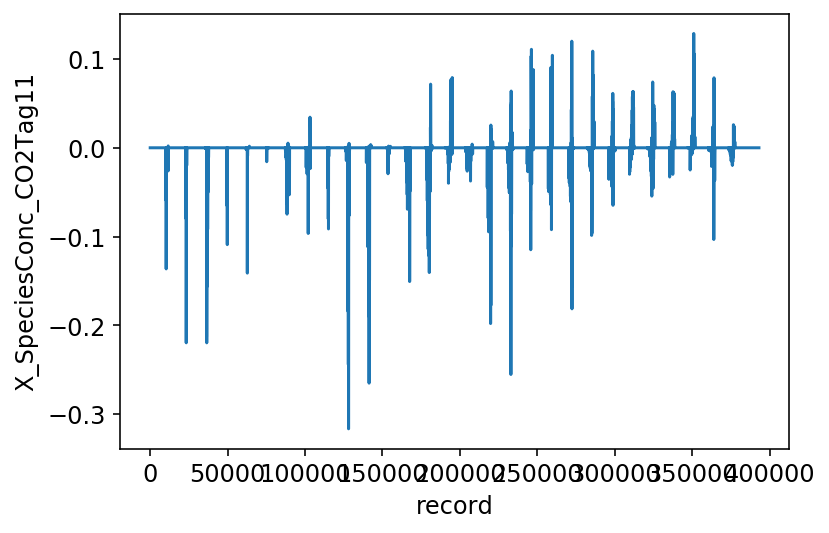

In [16]:
fname = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-casa-2018-09/nd51/delta_y0_model_N_9.nc'
#2d_ts_satellite.201801.nc'
ds = xr.open_dataset(fname)
var_name = 'X_SpeciesConc_CO2Tag11'
dr = ds[var_name]
dr.plot()
#dr = ds[var_name]-1e5
#dr[:,40].plot()
#diff = ds['SpeciesConc_CO2Tag1'] - ds['SpeciesConc_CO2Tag13']
#dr[:,0].plot()
#diff[:,45].plot()

In [24]:
# quite fast for one variable (<1m), but rather slow for 20+ tagged species (>15m)
def interpolate_model_to_satellite2(mod_dir, sat_dir, year, month, str1_mod, str1_sat, background):
    
    # read model and satellite files
    mod_file = str1_mod + str(year) + month_string(month) + '.nc'
    ds_mod = xr.open_dataset(mod_dir + mod_file)
    sat_file = str1_sat + str(year) + month_string(month) + '.nc'
    ds_sat = xr.open_dataset(sat_dir + sat_file)
    # read in variables and compute
    varnames = list(ds_mod.data_vars.keys())  # list of variable name
    needed_vars = [i for i in varnames if i.startswith('SpeciesConc_CO2Tag')] # species var names
    record            = ds_mod['record'].values
    levels_model      = ds_mod['levels']
    surf_press_mod    = ds_mod['PEDGE_S_PSURF']
    profile_press_mod = surf_press_mod * levels_model # model pressure at different levels
    profile_press_sat = ds_sat['pressure'] # satellite pressure profile of different levels
    # find records where measurements are available
    surf_press = profile_press_sat[:,19].values
    nonzero_record = np.where(surf_press != 0)[0] # loop over these records only
    # prepare output dataset
    interpolated = ds_sat['pressure'].to_dataset() # output dataset
    # variables need not to be interpolated
    noneed_interp = ['lat', 'lon', 'date']
    for ivar in noneed_interp: interpolated[ivar] = ds_mod[ivar].copy()
    # tmp dataarray to store interpolated output
    tmp = xr.DataArray(data = np.nan,
                       dims=('record', 'levels'),
                       coords=[record, ds_mod.levels])
    tmp = tmp.astype(dtype = 'float32')
    for ivar in needed_vars: interpolated[ivar] = tmp.copy()
    
    print('interpolation began')
    # interpolation
    for ivar in needed_vars:
        before = ds_mod[ivar] # co2 before interpolation
        for irecord in nonzero_record:
            var_before  = before[irecord,:].values - background*1e3 # a co2 profile, minus background (ppm to ppb)
            pres_before = np.log(profile_press_mod[irecord].values) # log space
            pres_after  = np.log(profile_press_sat[irecord])
            # linear interpolation on log space    
            interpolated[ivar][irecord,:] = np.interp(x  = pres_after, 
                                                      xp = np.flip(pres_before), # increasing order
                                                      fp = np.flip(var_before))
        print(ivar, 'done')
    
    output_file = mod_dir + 'interpolated_' + str1_mod + str(year) + month_string(month) + '.nc'
    interpolated.to_netcdf(output_file)
    
    print('created ' + 'interpolated_' + str1_mod + str(year) + month_string(month) + '.nc')


In [26]:
%%time
### this cell could do all post-processing for a case, over a few months, or one month

year = 2018

for imonth in [6]:

    case_name = 'CO2-bio-2018-' + month_string(imonth)
    mod_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/' + case_name + '/nd51/'

    interpolate_model_to_satellite2(mod_dir = mod_dir, 
                                       sat_dir = '/geos/u73/msadiq/satellite/oco-2/', 
                                       year = year, 
                                       month = imonth, 
                                       str1_mod = '2d_ts_satellite.', 
                                       str1_sat = '2d_OCO2_extract_',
                                       background = 100) # 100 ppm of background at all levels
    delta_Y(mod_dir = mod_dir, 
            sat_dir = '/geos/u73/msadiq/satellite/oco-2/', 
            year = year, 
            month = imonth, 
            str1_mod = 'interpolated_2d_ts_satellite.', 
            str1_sat = '2d_OCO2_extract_',
            mode = 'N')

interpolation began
SpeciesConc_CO2Tag1 done
SpeciesConc_CO2Tag2 done
SpeciesConc_CO2Tag3 done
SpeciesConc_CO2Tag4 done
SpeciesConc_CO2Tag5 done
SpeciesConc_CO2Tag6 done
SpeciesConc_CO2Tag7 done
SpeciesConc_CO2Tag8 done
SpeciesConc_CO2Tag9 done
SpeciesConc_CO2Tag10 done
SpeciesConc_CO2Tag11 done
SpeciesConc_CO2Tag12 done
SpeciesConc_CO2Tag13 done
SpeciesConc_CO2Tag14 done
SpeciesConc_CO2Tag15 done
SpeciesConc_CO2Tag16 done
SpeciesConc_CO2Tag17 done
SpeciesConc_CO2Tag18 done
SpeciesConc_CO2Tag19 done
SpeciesConc_CO2Tag20 done
SpeciesConc_CO2Tag21 done
SpeciesConc_CO2Tag22 done
created interpolated_2d_ts_satellite.201806.nc
created delta_y0_model_N_6.nc
CPU times: user 14min 35s, sys: 16.2 s, total: 14min 51s
Wall time: 14min 58s
